In [1]:
%matplotlib inline
import numpy as np
import sklearn.cluster
import sklearn.feature_extraction
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

###Fake Testing

In [2]:
# Generate a random data matrix. n = number of data points; m = length of each data point; num_types = number of types
def gen_data(n, m, num_types):
    # type for each data point (each from 0 to n-1)
    types = np.trunc(np.random.random_sample(n)*num_types)
    # list of random vectors of m integers between 20 and 40, to serve as the mean for each type
    means = [np.random.randint(20,40,m) for t in range(num_types)]
    # list of vectors of standard deviations for each type
    stddevs = 2 * np.ones([num_types,m])
    # generate a data matrix and round to the nearest thousandth
    return np.round(map(lambda t : list(np.random.randn(len(means[t])) * stddevs[t] + means[t]), map(int, types)),3)

In [3]:
# run k-means clustering on M, for each k values in k_vals
def k_mean_test(M, k_vals):
    results = []
    # sum of squared Euclidean distances from mean
    var = sum(np.var(M,0))*len(M)
    # loop through all k values provided
    for k in k_vals:
        # fit k-means clusterer
        fit = sklearn.cluster.KMeans(n_clusters=k).fit(M)
        # sum of squared Euclidean distance from cluster center
        within_var = sum(map(lambda r : min(r)**2, fit.transform(M)))
        results.append((fit, k, within_var/var))
    return results

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0000000000000002, 0.49175369268131686, 0.29979510248375152, 0.18873235427460394, 0.11449355774614466, 0.10654844124835618, 0.10095424060738399, 0.096028884321546867, 0.089155610597879215, 0.085966536440738914]]
Wall time: 318 ms


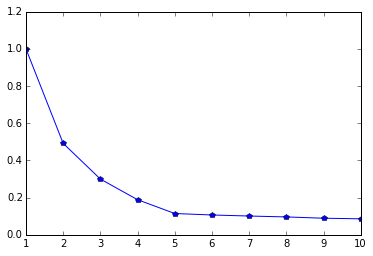

In [4]:
%%time
# generate 200 data points in R^4, with 5 topics
M = gen_data(200, 4, 5)
# plot results for k=1 to 10
results = k_mean_test(M, range(1,11))
plot_results = map(list, zip(*[(b,c) for a,b,c in results]))
print plot_results
plt.plot(plot_results[0], plot_results[1], 'p-')

###Fitting Model with Training Data

In [5]:
%%time
# read in data from csv
noun_train_mat = np.loadtxt("noun_train_mat.csv", delimiter = ",")
# use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(noun_train_mat)
noun_train_mat = tf_idf_fit.transform(noun_train_mat).toarray()

Wall time: 49.1 s


In [6]:
%%time
var = sum(np.var(noun_train_mat,0))*len(noun_train_mat)
kmeans_fit = sklearn.cluster.KMeans(n_clusters=14).fit(noun_train_mat)
within_var = sum(map(lambda r : min(r)**2, kmeans_fit.transform(noun_train_mat)))
#results.append((k, within_var/var))

#plot_results = map(list, zip(*k_mean_test(M, range(1,21))))
#print plot_results
#plt.plot(plot_results[0], plot_results[1], 'p-')

Wall time: 37.2 s


In [7]:
%%time
# use the fit above to cluster the data
clusters = kmeans_fit.predict(noun_train_mat)
cluster_lists = [[i for i,j in enumerate(clusters) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(clusters[clusters==i]) for i in range(14)]
# uncomment this loop to see a list of documents by cluster
#for cluster in range(14):
#    print
#    print 'Documents in category %s:' % cluster, cluster_lists[cluster]

Number of documents per cluster: [67, 89, 171, 11, 80, 36, 110, 71, 114, 15, 38, 145, 37, 126]
Wall time: 170 ms


###Comparing with Supreme Court Database's Topic Areas

In [8]:
# read in SC Database's issue areas from csv
noun_train_issue_areas = np.loadtxt("noun_train_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
noun_train_issue_areas = noun_train_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in noun_train_issue_areas]) for i in range(14)]

Number of documents per category: [238, 188, 96, 36, 10, 8, 64, 242, 131, 56, 10, 30, 1, 0]


In [9]:
compare_mat = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(clusters, noun_train_issue_areas):
    compare_mat[i][j] += 1
compare_mat = map(lambda row : map(float,row) / sum(row), np.array(compare_mat))

assignments = -1 * np.ones(14)
compare_mat_flat = [x for lst in compare_mat for x in lst]
while min(assignments) == -1:
    max_ind = np.argmax(compare_mat_flat)
    row = max_ind / 14
    if assignments[row] == -1:
        column = max_ind - 14 * row
        assignments[row] = column
    else:
        compare_mat_flat[max_ind] = -1
#5 / 2
assignments = map(int, assignments)
print assignments
print map(np.argmax, compare_mat)
print map(np.argmax, np.array(compare_mat).T)

print np.array(compare_mat)

[7, 0, 2, 7, 7, 1, 7, 6, 0, 10, 1, 8, 1, 8]
[7, 0, 2, 7, 7, 1, 7, 6, 0, 10, 1, 8, 1, 8]
[8, 5, 2, 12, 2, 11, 7, 3, 13, 9, 9, 0, 0, 0]
[[ 0.14925373  0.04477612  0.          0.          0.          0.01492537
   0.          0.37313433  0.04477612  0.04477612  0.          0.31343284
   0.01492537  0.        ]
 [ 0.71910112  0.13483146  0.02247191  0.02247191  0.          0.          0.
   0.05617978  0.04494382  0.          0.          0.          0.          0.        ]
 [ 0.29824561  0.19298246  0.31578947  0.00584795  0.03508772  0.01169591
   0.00584795  0.07017544  0.03508772  0.02339181  0.          0.00584795
   0.          0.        ]
 [ 0.09090909  0.          0.          0.          0.          0.          0.
   0.72727273  0.09090909  0.09090909  0.          0.          0.          0.        ]
 [ 0.025       0.25        0.0375      0.025       0.          0.          0.05
   0.5625      0.025       0.0125      0.          0.0125      0.          0.        ]
 [ 0.05555556  0.63

In [10]:
new_clusters = map(lambda cluster : assignments[cluster], clusters)
correct = map(lambda (c1,c2) : c1==c2, zip(new_clusters, noun_train_issue_areas))
print float(sum(correct)) / len(correct)

0.484684684685


###Applying Model to Test Data

In [11]:
%%time
# read in test data from csv
noun_test_mat = np.loadtxt("noun_test_mat.csv", delimiter = ",")
# use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
noun_test_mat = tf_idf_fit.transform(noun_test_mat).toarray()

Wall time: 29 s


In [12]:
%%time
# use NMF fit from training data to cluster test observations
clusters_test = kmeans_fit.predict(noun_test_mat)
cluster_lists_test = [[i for i,j in enumerate(clusters_test) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(clusters_test[clusters_test==i]) for i in range(14)]
# uncomment this loop to see a list of documents by cluster
#for cluster in range(14):
#    print
#    print 'Documents in category %s:' % cluster, cluster_lists_test[cluster]

Number of documents per cluster: [31, 36, 105, 6, 31, 5, 42, 24, 47, 6, 15, 53, 15, 69]
Wall time: 82 ms


###Compare Test Data Results to SC Database Categories

In [13]:
# read in SC Database's issue areas from csv
noun_test_issue_areas = np.loadtxt("noun_test_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
noun_test_issue_areas = noun_test_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in noun_test_issue_areas]) for i in range(14)]

Number of documents per category: [104, 95, 26, 22, 3, 7, 18, 96, 63, 25, 5, 17, 4, 0]


In [14]:
new_clusters_test = map(lambda cluster : assignments[cluster], clusters_test)
correct_test = map(lambda (c1,c2) : c1==c2, zip(new_clusters_test, noun_test_issue_areas))
print float(sum(correct_test)) / len(correct_test)

0.424742268041
